## This notebook is for the MIT class 6.438 (Algorithms for Inference). We use PyMC3 to demonstrate how MCMC methods are used in practice, starting with some basic examples then demonstrating an example application: Gelman et. al.'s (2007) radon dataset, taken from the [PyMC3 examples](https://docs.pymc.io/notebooks/Diagnosing_biased_Inference_with_Divergences.html)

# Setup

### Plotting

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline
sns.set()
mpl.rcParams['figure.figsize'] = (10, 3)

### Data manipulation

In [2]:
import numpy as np
import pymc3 as pm
import pandas as pd

### Other

In [3]:
SEED = 1729
import random
random.seed(SEED)
np.random.seed(SEED)
import operator as op

# Hypercube Example

#### Model/Sampler Parameters

In [4]:
dims = 10
nsamples = 1000

#### MCMC Steps: normally, we should just use the built-in methods, but since we're doing something much simpler than one would do in practice, we need to define the method ourselves

In [5]:
class HypercubeMetropolis(pm.Metropolis):
    def __init__(self, stochastic):
        pm.Metropolis.__init__(self, stochastic, scale=1., proposal_sd='custom',
            proposal_distribution='custom', verbose=None, tally=False)

    def astep(self, q0):
        ix = np.random.randint(len(q0))
        newval = np.random.binomial(1, .5)
        q_new = q0.copy()
        q_new[ix] = newval
        return q_new, []

#### Sample starting with all 0's to show how it takes the chain a while to mix. Turn off tuning for now so we see all the samples.

In [6]:
with pm.Model() as model:
    coords = pm.Bernoulli('coords', p=.5, shape=[dims])
    start = {'coords': np.zeros(dims)}
    samples = pm.sample(nsamples, step=HypercubeMetropolis(coords), start=start, chains=1, tune=False, random_seed=SEED)
s1 = samples.get_values('coords', chains=[0])

Sequential sampling (1 chains in 1 job)
HypercubeMetropolis: [coords]
100%|██████████| 1000/1000 [00:00<00:00, 1955.75it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


#### Use Hoeffding's Inequality https://en.wikipedia.org/wiki/Hoeffding%27s_inequality to bound tail probabilities (i.e., probability the mean deviates from its expected value). This lets us convince ourselves that the first few samples are indeed atypical.

In [7]:
confidence = .80
k = np.sqrt(-np.log((1-confidence)/2)/2/dims)
low = .5 - k
high = .5 + k

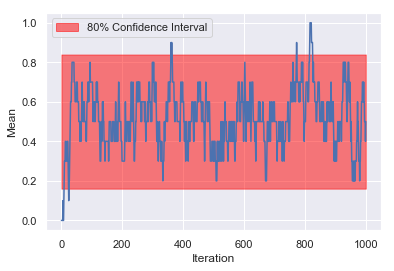

In [8]:
plt.fill_between(np.arange(nsamples), low, high, alpha=.5, color='red', label='%s%% Confidence Interval' % (int(confidence*100)))
plt.xlabel('Iteration')
plt.ylabel('Mean')
plt.plot(np.arange(nsamples), s1.mean(axis=1));
plt.legend();

#### Check numerically that we indeed have most of our samples in the confidence interval

In [9]:
in_conf = np.logical_and(s1.mean(axis=1) > low, s1.mean(axis=1) < high)
print(sum(in_conf))

977


#### A bit more realistic: run chains from multiple starting points. 

We need to do this in case the distribution is multimodal: a chain could appear to stabilize, but get stuck in a single "mode" of the distribution. If another chain is started from somewhere else, it's likely to find a different mode, and by comparing trace plots between the chains we might be able to tell that we haven't run our chains long enough.

In [10]:
nsamples = 50

In [11]:
with pm.Model() as model:
    coords = pm.Bernoulli('coords', p=.5, shape=[dims])
    start = [{'coords': np.zeros(dims)}, {'coords': np.ones(dims)}, {'coords': np.random.binomial(1, .5, size=dims)}]
    samples = pm.sample(nsamples, step=HypercubeMetropolis(coords), start=start, chains=3, random_seed=SEED, tune=False)
s0 = samples.get_values('coords', chains=[0])
s1 = samples.get_values('coords', chains=[1])
s2 = samples.get_values('coords', chains=[2])

Only 50 samples in chain.
Multiprocess sampling (3 chains in 2 jobs)
HypercubeMetropolis: [coords]
Sampling 3 chains: 100%|██████████| 150/150 [00:00<00:00, 3975.84draws/s]
/Users/chandlersquires/Documents/6438-mcmc-case-study/venv/lib/python3.6/site-packages/pymc3/sampling.py:476: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


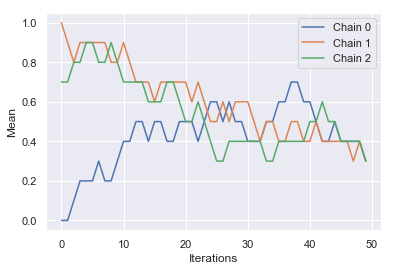

In [12]:
plt.xlabel('Iterations')
plt.ylabel('Mean')
plt.plot(np.arange(nsamples), s0.mean(axis=1), label='Chain 0');
plt.plot(np.arange(nsamples), s1.mean(axis=1), label='Chain 1');
plt.plot(np.arange(nsamples), s2.mean(axis=1), label='Chain 2');
plt.legend();

# Gaussian Example

#### Even more realistic: run chains from multiple starting points, with burn-in.

If we're going to compute some statistic about our distribution, and the initial values are wildly atypical, it's better to leave them out. The hypercube example isn't great to illustrate this point so we'll switch to a normal distribution.

In [13]:
burn = 30
nsamples = 100

In [14]:
with pm.Model() as model:
    x = pm.Normal('x', 0, 1)
    start = [{'x': 10}, {'x': -10}, {'x': 0}]
    samples = pm.sample(nsamples + burn, step=pm.Metropolis(x), start=start, chains=3, random_seed=SEED, tune=False)
s0 = samples.get_values('x', chains=[0])
s1 = samples.get_values('x', chains=[1])
s2 = samples.get_values('x', chains=[2])

Only 130 samples in chain.
Multiprocess sampling (3 chains in 2 jobs)
Metropolis: [x]
Sampling 3 chains: 100%|██████████| 390/390 [00:00<00:00, 3591.96draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


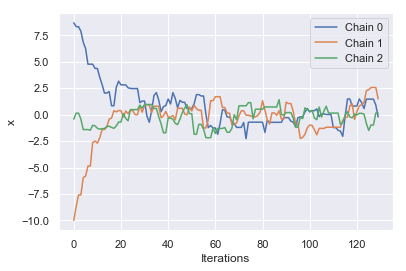

In [15]:
plt.xlabel('Iterations')
plt.ylabel('x')
plt.plot(s0, label='Chain 0');
plt.plot(s1, label='Chain 1');
plt.plot(s2, label='Chain 2');
plt.legend();

In [16]:
print('Mean without burn-in:')
print(samples.get_values('x', chains=[0])[:nsamples].mean())
print('Mean with burn-in:')
print(samples.get_values('x', chains=[0], burn=burn).mean())

Mean without burn-in:
1.110146259419762
Mean with burn-in:
0.07349531035888063


#### Running multiple chains also allows us to compute $\hat{R}$ (pronounced "R hat", also known as the Rubin-Gelman statistic or the "potential scale reduction factor"), which can help use tell whether we've run the chains long enough. We want $\hat{R} \approx 1$, the recommendation is to run the chains at least long enough so that $\hat{R} < 1.1$

I won't write out the exact formula of $\hat{R}$: the details are less important than the idea. $\hat{R}$ compares the variance of the samples from a single chain (the within-chain variance) to the variance of the samples from all the chains (the between-chain variance). Assume that our initialization is "overdispersed" (i.e., our starting values have more variety than the true distribution). Then, if the chains haven't converged, the between-chain variance will be overestimated, since it includes these initializations. Meanwhile, the within-chain variance will be underestimated, since they haven't had time to explore the whole distribution. $\hat{R}$ basically takes a ratio of the between-chain variance and the average within-chain variance (with some adjustments to account for the fact that these are just estimates of the variance). If the chains have converged, both ways of estimating the variance will be unbiased, so $\hat{R}$ will be close to 1.

In [17]:
pm.summary(samples, start=burn)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
x,-0.017265,1.006188,0.090827,-1.909887,1.890778,14.576145,1.084239


# Gaussian Mixture Model

#### Now we can actually see a case where multiple chains comes in handy

In [18]:
with pm.Model() as model:
    x = pm.NormalMixture('x', [.5, .5], [-3, 3])
    start = [{'x': 10}, {'x': -10}, {'x': 0}]
    samples = pm.sample(nsamples + burn, step=pm.Metropolis(x), start=start, chains=3, random_seed=SEED, tune=False)
s0 = samples.get_values('x', chains=[0])
s1 = samples.get_values('x', chains=[1])
s2 = samples.get_values('x', chains=[2])

Only 130 samples in chain.
Multiprocess sampling (3 chains in 2 jobs)
Metropolis: [x]
Sampling 3 chains: 100%|██████████| 390/390 [00:00<00:00, 3933.43draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


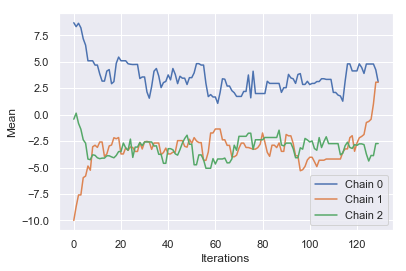

In [ ]:
plt.xlabel('Iterations')
plt.ylabel('Mean')
plt.plot(s0, label='Chain 0');
plt.plot(s1, label='Chain 1');
plt.plot(s2, label='Chain 2');
plt.legend();

In [ ]:
pm.summary(samples)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
x,-0.918809,3.450428,0.357611,-4.91442,5.089635,1.778746,3.040727


# MCMC in Practice

So far, we've only seen MCMC on some distributions that are already very easy to sample from, which is good for building some intutition, but of we'd never use MCMC in these cases.

A common case where MCMC methods come in handy is in Bayesian inference, which is built around the idea of a *generative model*. This is a probabilistic model that's meant to explain how some collected data was generated; involving some *latent (i.e., unobserved) variables*. Some examples:
* A trader might model the daily returns on a stock (the observed data) as a function of two latent variables: the true daily increase in the value of the stock, and market volatility, which is shared across many stocks.
* An internet search company that wants to return webpages for keyword searches might model each webpage as a mixture of topics, each topic itself being a mixture of words
* A medical researcher interested in the effectiveness of a treatment (say, mastectomy as a treatment for breast cancer) in terms of survival time after the treatment. The survival time might be modeled as a linear function of the patient covariates (e.g. age, income, disease progression), but the survival time is only lower-bounded for patients who survive for the whole time they are monitored.

Each of the latent variables will have a *prior distribution* that is based on domain expertise and represents the beliefs of the modeler before the data is taken into account. For example, the trader might expect the daily increases of stocks to be independent and centered around 0, and the volatility on any day to be the sum of the volatility the day before plus some 0-mean noise.

The goal of the researcher is to determine the *posterior distribution* of the latent variables: the distribution after conditioning on the observed data. If the latent variables are denoted by $\Theta$, and the observed variables are denoted as $X$, the posterior distribution will be 
$$p(\Theta | X) = \frac{p(\Theta) p(X | \Theta)}{p(X)}$$
where $p(\Theta)$ is the prior and $p(X | \Theta)$ is the likelihood model, both usually specified in closed form. As we've seen, the difficulty lies in computing the normalization constant $p(X)$, which is in this case usually called the *evidence*. One method we've seen is variational inference: we can lower bound $p(X)$ be optimizing over a simpler model class, such as all variables being independent. In this context, the the lower bound on $p(X)$ is called the *evidence lower bound (ELBO)*. The downside of these methods is that they can only ever give approximations; MCMC methods on the other hand can provide samples from the true distribution if the chains are run for long enough.

 PyMC3 (along with other popular probabilistic programming libraries/languages, such as Edward and Stan) make it easy to specify a model, feed in data, and run either variational or MCMC methods to determine posteriors. This takes the burden off of the user to implement the algorithms themselves, but it is still important to know how to check the results of these models. In most applied settings, there are no proofs on mixing time, so diagnostic criteria (like those discussed above) must be used instead.

## Case Study: Radon Concentration

Radon is a radioactive gas, known to be the highest cause of lung-cancer in non-smokers. It is found in varying degrees in different households, and the concentration is believed to depend on soil composition, and to be higher in houses with a basement. This dataset is from households in all 85 counties of Minnesota, with between 2 and 116 measurements per county. We'll try out two simple models to predict the radon levels of a household. For some reason, floor=0 denotes that there's a basement, and floor=1 denotes that there isn't a basement. 

#### Get the dataset and check out the relevant features

In [ ]:
data = pd.read_csv(pm.get_data('radon.csv'))
data[['county', 'log_radon', 'floor']].head()

,county,log_radon,floor
0,AITKIN,0.832909,1.0
1,AITKIN,0.832909,0.0
2,AITKIN,1.098612,0.0
3,AITKIN,0.095310,0.0
4,ANOKA,1.163151,0.0


#### Divide data by county

In [ ]:
county_names = data.county.unique()
county_idx = data.county_code.values
n_counties = len(county_names)

### First model: separate linear regressions for each county

In [ ]:
with pm.Model() as unpooled_model:
    # Independent parameters for each county
    a = pm.Normal('a', 0, sd=100, shape=n_counties)
    b = pm.Normal('b', 0, sd=100, shape=n_counties)

    # Model error
    eps = pm.HalfCauchy('eps', 5)

    # Model prediction of radon level
    radon_est = a[county_idx] + b[county_idx]*data.floor.values

    # Data likelihood
    y = pm.Normal('y', radon_est, sd=eps, observed=data.log_radon)

#### We can visualize the model in what is called *plate notation*. As always, an oval represents a variable. A variable is a function of all of its parents. A plate (rectangle) with $n$ in the corner is shorthand for there being $n$ conditionally independent copies of the variable. Shading represents that the variable has been observed.

In this case, we have 85 separate i.i.d. linear coefficients $a$ and $b$, and 919 separate observed radon levels, each of which is normal with mean $a_i$ if there is a basement and $a_i + b_i$ if there is not a basement (where $i$ is the index of the county). This is a slight abuse of the plate notation as described above (since it's not clear from the notation how individual $y$'s are associated to $a_i$'s and $b_i$'s), but it gets the point across.

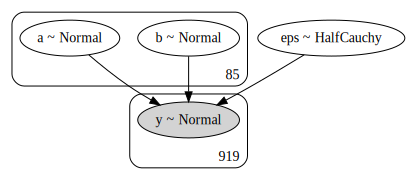

In [ ]:
pm.model_to_graphviz(unpooled_model)

### We'll first use Metropolis updates

In [ ]:
with unpooled_model:
    unpooled_trace_mh = pm.sample(5000, step=pm.Metropolis())

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [eps]
>Metropolis: [b]
>Metropolis: [a]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:03<00:00, 3144.42draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


#### As we can see, even 5000 Metropolis updates isn't enough to converge

In [ ]:
rhats_mh = pm.summary(unpooled_trace_mh).Rhat

In [ ]:
rhats_mh.to_frame().nlargest(10, 'Rhat')

,Rhat
b__30,9.145250
b__71,7.438464
a__16,6.948815
a__22,6.652632
b__50,6.411092
a__55,4.623200
b__81,4.566689
b__73,4.120297
b__59,3.928216
b__16,3.673534


Random Walk Metropolis-Hastings often gives very slow convergence in complex models. In continuous settings, MH usually generates proposals by adding zero-mean Gaussian noise to each variable. The only tuning parameter is the variance of the noise. If the variance is too high, most of the proposals will be far away from where most of the probability mass is, landing in regions of low probability density, and most proposals will be rejected. If the variance is low, we'll accept more often, but it'll take a long time to go anywhere: the MH steps are exploring randomly and will exhibit random walk behavior. In one dimension, the distance traveled in $t$ steps grows as $O(\sqrt{t})$. This only gets worse in higher dimensions.

#### Now, we'll use Hamiltonian Monte Carlo (HMC) along with the state-of-the-art NUTS (No-U-Turn-Sampler) modification. We won't get into the details of either in this class... 

...but since I can't resist, the basic idea is to avoid random walk behavior by making smarter proposals. These smarter proposals both travel far and have a high acceptance probability by adding "momentum" to the system at the beginning of each iteration and simulating Hamiltonian dynamics, with $-\log(\tilde{p}(x))$ as the potential energy (so more probable configurations have lower potential energy). The interplay between momentum and potential energy as the Hamiltonian dynamics goes on allows us to avoid low-probability (high potential-energy) regions, since the momentum decreases in those directions, but travel far, since we can simulate the dynamics as long as we want.

Check out Michael Betancourt's [Youtube video](https://youtu.be/jUSZboSq1zg) for a great explanation with lots of visuals. If you use HMC/NUTS in practice, there are other good diagnostics that you can find in Gabry et. al.'s paper on [Visualization in Bayesian workflow](https://arxiv.org/abs/1709.01449).

In [ ]:
with unpooled_model:
    unpooled_trace_nuts = pm.sample(5000, step=pm.NUTS())

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, b, a]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:18<00:00, 584.82draws/s]


#### Much better!

In [ ]:
rhats_nuts = pm.summary(unpooled_trace_nuts).Rhat

In [ ]:
rhats_nuts.to_frame().nlargest(10, 'Rhat')

,Rhat
b__67,1.000479
b__46,1.000250
b__36,1.000231
b__72,1.000211
a__21,1.000206
b__37,1.000200
b__7,1.000177
a__39,1.000141
a__75,1.000137
a__46,1.000112


## Second Model: pooled linear regression

In [ ]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_a', mu=0., sd=100**2)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0., sd=100**2)
    sigma_b = pm.HalfCauchy('sigma_b', 5)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_counties)
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=n_counties)

    # Model error
    eps = pm.HalfCauchy('eps', 5)

    radon_est = a[county_idx] + b[county_idx] * data.floor.values

    # Data likelihood
    radon_like = pm.Normal('radon_like', mu=radon_est, sd=eps, observed=data.log_radon)

Notice what's changed: the $a$'s and $b$'s are no longer conditionally independent, but are each normals whose means and variances are themselves drawn from a latent distribution. This lets us share some statistical power across the counties, which is a sensible thing to do, especially for $b$, since we'd expect the presence of the basement to have similar effect regardless of county

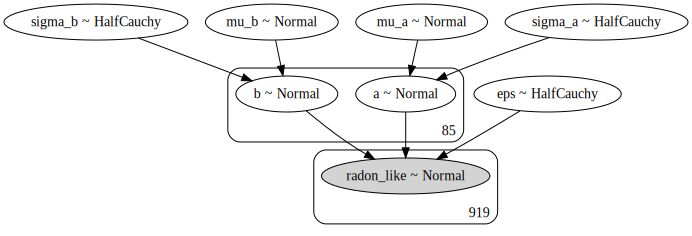

In [ ]:
pm.model_to_graphviz(hierarchical_model)

In [ ]:
with hierarchical_model:
    hierarchical_trace = pm.sample(5000, n_init=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling 2 chains:  42%|████▏     | 4582/11000 [00:17<00:21, 299.56draws/s]

#### There are many ways to compare the performance of these models - we'll look at some of the ones that PyMC3 provides by default. WAIC is a type of *information criterion* , so like BIC (Bayesian Information Criterion), it generally it tells us how good the predictive performance is versus the number of parameters. A lower value is better.

Unfortunately, PyMC3 uses the order of the models in the dictionary to specify the index in the dataframe: in this case, the hierarchical model has index 1 and the unpooled model has index 0. The hierarchical model is indeed better.

In [ ]:
pm.compare({unpooled_model: unpooled_trace_nuts, hierarchical_model: hierarchical_trace})